In [ ]:
##UPDATE REQUIREMENTS

import pkg_resources

packages = ["torch", "torchvision", "torchaudio", "numpy", 
            "nibabel", "nilearn", "scikit-image", "Pillow", 
            "matplotlib", "scipy", "tqdm"]

with open("requirements.txt", "w") as f:
    for p in packages:
        try:
            version = pkg_resources.get_distribution(p).version
            f.write(f"{p}=={version}\n")
        except pkg_resources.DistributionNotFound:
            print(f"⚠️ {p} not installed")

In [321]:
# image = nib.load(filepath).get_fdata() #Load image data
# image = (image - np.min(image1))/np.max(image) - np.min(image1)
# img = Image.fromarray((image[:,:,50] * 225).astype(np.uint8))
# img
# hist_data, bin_edges = np.histogram(img, bins = 256, range=(0,225))
# hist_data.shape
# plt.imshow(img)
# plt.plot(bin_edges[0:-1], hist_data)
# plt.ylim(0, 700)

# plt.hist(image.flatten(), bins = 256)
# plt.ylim(0, 2*10**4.4)

In [414]:
import torch 
import torch.nn as nn
import numpy as np
import nibabel as nib
import os
import PIL.Image as Image
import matplotlib.pyplot as plt
import skimage as ski

In [416]:
filepath = "data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"

In [418]:
# Loading data and extracting image data with "get_fdata()"
test_t1_image = nib.load(filepath + "BraTS20_Training_001_t1.nii").get_fdata()
test_t1ce_image = nib.load(filepath + "BraTS20_Training_001_t1ce.nii").get_fdata()
test_t2_image = nib.load(filepath + "BraTS20_Training_001_t2.nii").get_fdata()
test_flair_image = nib.load(filepath + "BraTS20_Training_001_flair.nii").get_fdata()
test_mask = nib.load(filepath + "BraTS20_Training_001_seg.nii").get_fdata()

Text(0.5, 1.0, 'seg mask')

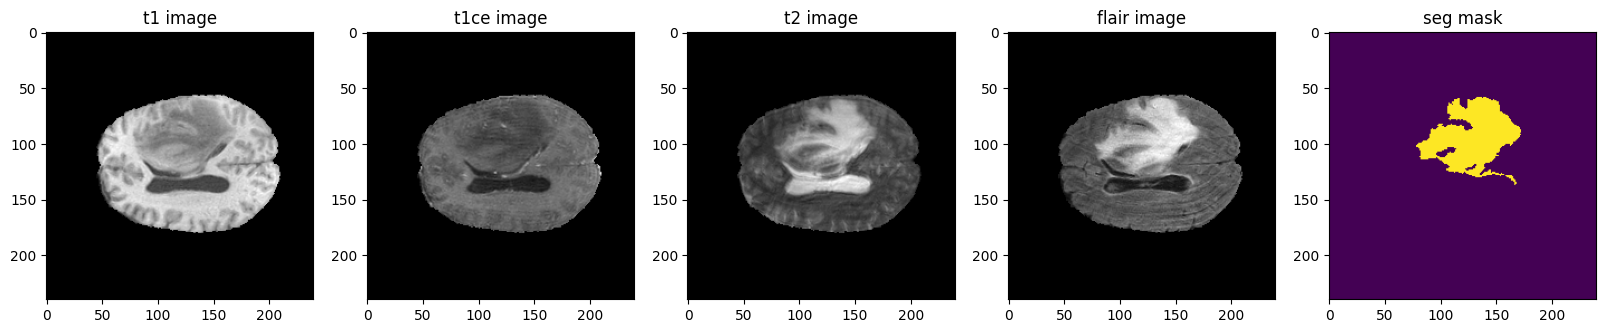

In [420]:
volume_show = 89 #Orientation to view 

# Visualizing sample of Image data

fig , (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 10))

ax1.imshow(test_t1_image[:,:,volume_show], cmap = "gray")
ax1.set_title("t1 image")

ax2.imshow(test_t1ce_image[:,:,volume_show], cmap = "gray")
ax2.set_title("t1ce image")

ax3.imshow(test_t2_image[:,:,volume_show], cmap = "gray")
ax3.set_title("t2 image")

ax4.imshow(test_flair_image[:,:,volume_show], cmap = "gray")
ax4.set_title("flair image")

ax5.imshow(test_mask[:,:,volume_show])
ax5.set_title("seg mask")

In [432]:
import nilearn.plotting as nlplt
import nilearn as nl

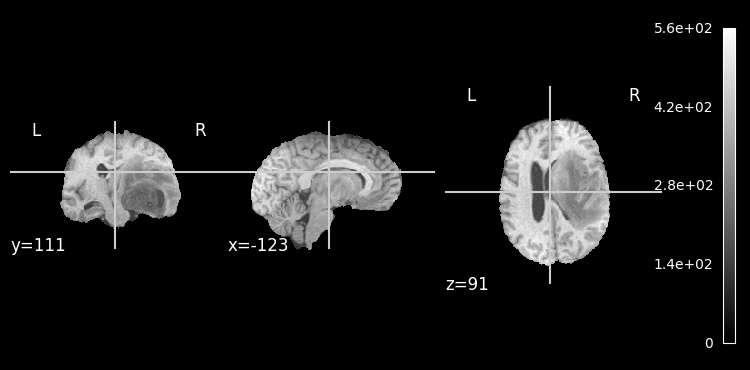

In [458]:
nl_test_t1_image = nl.image.load_img(filepath + "BraTS20_Training_001_t1.nii")

nlplt.plot_epi(nl_test_t1_image)

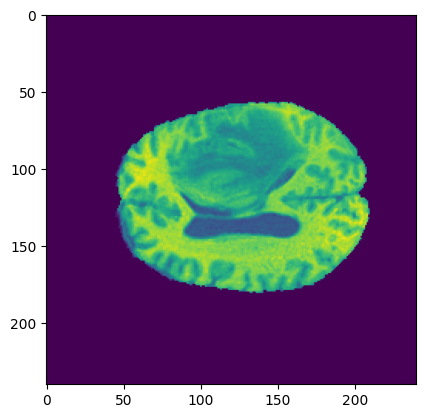

In [466]:
plt.imshow(nl_test_t1_image.get_fdata()[:,:, 89])

In [468]:
def load_nifti(filepath):
    """Load a NIfTI MRI file as numpy array"""
    img = nib.load(filepath)
    data = img.get_fdata().astype(np.float32)
    return data, img.affine, img.header


In [472]:
data, img.affine, img.header = load_nifti(filepath + "BraTS20_Training_001_t1.nii")

In [480]:
img.affine

array([[ -1.,  -0.,  -0.,   0.],
       [ -0.,  -1.,  -0., 239.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.]])